# Implementierung eines SNN und CNN: Ein Vergleich mit dem CIFAR-10-Datensatz


*Author: Ümmühan Ay*

Schritt 1: Alle nötigen Imports importieren

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import time

Schritt 2: Cuda benutzen

In [2]:
device = torch.device("cuda")

Schritt 3: Implementierung des SNN und des LIF

In [3]:
class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        surrogate_grad = torch.exp(-input.abs())  # Glatte Ableitung
        return grad_output * surrogate_grad

spike_fn = SurrogateSpike.apply

In [4]:
class SNN(nn.Module):
     def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size,
                 v_rest=-65.0, v_thresh=-50.0, v_reset=-65.0, tau_mem=10.0):
        super(SNN, self).__init__()
        self.v_rest = v_rest
        self.v_thresh = v_thresh
        self.v_reset = v_reset
        self.tau_mem = tau_mem

        # Synaptische Gewichte
        self.synapse1 = nn.Parameter(torch.randn(input_size, hidden_size1) * 0.1)
        self.synapse2 = nn.Parameter(torch.randn(hidden_size1, hidden_size2) * 0.1)
        self.synapse3 = nn.Parameter(torch.randn(hidden_size2, hidden_size3) * 0.1)
        self.fc_out = nn.Linear(hidden_size3, output_size)

        # BatchNorm für Stabilisierung
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.bn3 = nn.BatchNorm1d(hidden_size3)

     def forward(self, x, dt=1e-3):
        batch_size, time_steps, _ = x.shape

        # Initialisiere Membranpotenziale
        v1 = torch.full((batch_size, self.synapse1.shape[1]), self.v_rest, device=x.device)
        v2 = torch.full((batch_size, self.synapse2.shape[1]), self.v_rest, device=x.device)
        v3 = torch.full((batch_size, self.synapse3.shape[1]), self.v_rest, device=x.device)

        spikes1 = torch.zeros(batch_size, time_steps, self.synapse1.shape[1], device=x.device)
        spikes2 = torch.zeros(batch_size, time_steps, self.synapse2.shape[1], device=x.device)
        spikes3 = torch.zeros(batch_size, time_steps, self.synapse3.shape[1], device=x.device)

        for t in range(time_steps):
            z0 = x[:, t, :]  # Input

            v1 += (self.v_rest - v1) * (dt / self.tau_mem) + torch.matmul(z0, self.synapse1)
            z1 = spike_fn(v1 - self.v_thresh)
            v1 = torch.where(z1 > 0, torch.tensor(self.v_reset, device=x.device), v1)
            spikes1[:, t, :] = z1

            v2 += (self.v_rest - v2) * (dt / self.tau_mem) + torch.matmul(z1, self.synapse2)
            z2 = spike_fn(v2 - self.v_thresh)
            v2 = torch.where(z2 > 0, torch.tensor(self.v_reset, device=x.device), v2)
            spikes2[:, t, :] = z2

            v3 += (self.v_rest - v3) * (dt / self.tau_mem) + torch.matmul(z2, self.synapse3)
            z3 = spike_fn(v3 - self.v_thresh)
            v3 = torch.where(z3 > 0, torch.tensor(self.v_reset, device=x.device), v3)
            spikes3[:, t, :] = z3

        # Summe der Spikes → Klassifizierung
        summed = spikes3.mean(dim=1)
        summed = self.bn3(summed)
        output = self.fc_out(summed)
        return output

Schritt 4: MNIST-Datensatz laden

Test mit MNIST

Test mit Kanji-Datensatz

In [5]:
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # Mittelwerte für CIFAR-10 (RGB)
                         (0.2023, 0.1994, 0.2010))  # Standardabweichungen
])

# CIFAR-10 Dataset laden (train und test)
train_dataset = datasets.CIFAR10(root='./cifar-10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./cifar-10', train=False, download=False, transform=transform)
# # Nur 900 Trainingsdaten & 100 Testdaten
#train_subset = Subset(train_dataset, range(27000))
#test_subset = Subset(test_dataset, range(3000))
# Trainings- und Test-Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def image_to_spikes(images, time_steps, threshold=0.0):
    images = images.view(images.size(0), -1)  # (B, 3072)
    spikes = torch.zeros((images.size(0), time_steps, images.size(1)), device=images.device)
    for t in range(time_steps):
        spikes[:, t, :] = (torch.rand_like(images) < images).float()
    return spikes

Files already downloaded and verified


Schritt 5: CNN erstellen

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

        # BatchNorm für Convolutional Layer
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        # Convolutional Layers mit BatchNorm und ReLU
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # 32x32 → 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # 16x16 → 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # 8x8 → 4x4
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

6. Hyperparameter, Loss-Funktion und Optimizer definieren

In [ ]:
# Hyperparameter
input_size = 32 * 32 * 3
hidden_size1 = 512
hidden_size2 = 512
hidden_size3 = 512
output_size = 10
epochs = 50
time_steps = 10

snn_model = SNN(
    input_size=input_size,
    hidden_size1=hidden_size1,
    hidden_size2=hidden_size2,
    hidden_size3=hidden_size3,
    output_size=output_size
).to(device)
cnn_model = SimpleCNN().to(device)

snn_optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

snn_loss_fn = torch.nn.CrossEntropyLoss()
cnn_loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
start = time.time()

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()
start_memory = torch.cuda.memory_allocated()

7. Training SNN

In [9]:
for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Spikes generieren
        spike_input = image_to_spikes(images, time_steps)

        # Forward + Loss
        outputs = snn_model(spike_input)
        loss = snn_loss_fn(outputs, labels)

        # Backward + Optimierung
        snn_optimizer.zero_grad()
        loss.backward()
        snn_optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 1 Loss: 2.2984
Epoch 2 Loss: 2.2967
Epoch 3 Loss: 2.3000
Epoch 4 Loss: 2.2997
Epoch 5 Loss: 2.3029
Epoch 6 Loss: 2.3057
Epoch 7 Loss: 2.3025
Epoch 8 Loss: 2.2984
Epoch 9 Loss: 2.3063
Epoch 10 Loss: 2.3092
Epoch 11 Loss: 2.2940
Epoch 12 Loss: 2.2997
Epoch 13 Loss: 2.3213
Epoch 14 Loss: 2.3007
Epoch 15 Loss: 2.2950
Epoch 16 Loss: 2.3047
Epoch 17 Loss: 2.3156
Epoch 18 Loss: 2.3078
Epoch 19 Loss: 2.3029
Epoch 20 Loss: 2.2966
Epoch 21 Loss: 2.3003
Epoch 22 Loss: 1.9766
Epoch 23 Loss: 2.4898
Epoch 24 Loss: 1.6246
Epoch 25 Loss: 1.4479
Epoch 26 Loss: 1.8181
Epoch 27 Loss: 1.6756
Epoch 28 Loss: 1.9021
Epoch 29 Loss: 1.3235
Epoch 30 Loss: 1.9794


In [10]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 905.57 Sekunden
Maximale GPU-Speichernutzung: 66.22 MB


8. CNN trainieren

In [11]:
scheduler = torch.optim.lr_scheduler.StepLR(cnn_optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        cnn_optimizer.zero_grad()
        outputs = cnn_model(images)
        
        cnn_loss = cnn_loss_fn(outputs, labels)
        cnn_loss.backward()
        cnn_optimizer.step()
        torch.cuda.empty_cache()
        
        running_loss += cnn_loss.item()

    # Lernratenplaner verwenden
    scheduler.step()

    print(f'Epoch [{epoch+1}/{epochs}], CNN Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/30], CNN Loss: 1.1532
Epoch [2/30], CNN Loss: 0.8028
Epoch [3/30], CNN Loss: 0.6562
Epoch [4/30], CNN Loss: 0.5483
Epoch [5/30], CNN Loss: 0.4568
Epoch [6/30], CNN Loss: 0.3767
Epoch [7/30], CNN Loss: 0.3054
Epoch [8/30], CNN Loss: 0.2485
Epoch [9/30], CNN Loss: 0.2000
Epoch [10/30], CNN Loss: 0.1643
Epoch [11/30], CNN Loss: 0.0629
Epoch [12/30], CNN Loss: 0.0386
Epoch [13/30], CNN Loss: 0.0274
Epoch [14/30], CNN Loss: 0.0211
Epoch [15/30], CNN Loss: 0.0165
Epoch [16/30], CNN Loss: 0.0125
Epoch [17/30], CNN Loss: 0.0101
Epoch [18/30], CNN Loss: 0.0080
Epoch [19/30], CNN Loss: 0.0068
Epoch [20/30], CNN Loss: 0.0059
Epoch [21/30], CNN Loss: 0.0039
Epoch [22/30], CNN Loss: 0.0033
Epoch [23/30], CNN Loss: 0.0032
Epoch [24/30], CNN Loss: 0.0032
Epoch [25/30], CNN Loss: 0.0030
Epoch [26/30], CNN Loss: 0.0029
Epoch [27/30], CNN Loss: 0.0028
Epoch [28/30], CNN Loss: 0.0026
Epoch [29/30], CNN Loss: 0.0027
Epoch [30/30], CNN Loss: 0.0025


In [12]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 1475.86 Sekunden
Maximale GPU-Speichernutzung: 92.03 MB


9. SNN Evaluieren

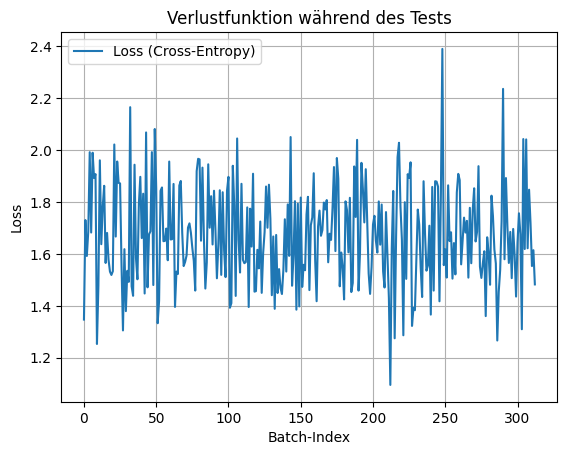

Accuracy (SNN): 39.93%
F = 0.000, p = 1.000
              precision    recall  f1-score   support

           0       0.51      0.46      0.48      1000
           1       0.53      0.36      0.43      1000
           2       0.31      0.23      0.27      1000
           3       0.27      0.30      0.28      1000
           4       0.42      0.15      0.22      1000
           5       0.40      0.31      0.35      1000
           6       0.34      0.65      0.45      1000
           7       0.46      0.41      0.43      1000
           8       0.46      0.55      0.50      1000
           9       0.40      0.58      0.47      1000

    accuracy                           0.40     10000
   macro avg       0.41      0.40      0.39     10000
weighted avg       0.41      0.40      0.39     10000



In [13]:
from sklearn.metrics import classification_report
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import f_oneway

snn_model.eval()
correct = 0
total = 0
loss_values = []

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        spikes = image_to_spikes(images, time_steps).to(device)

        outputs = snn_model(spikes)
        loss = snn_loss_fn(outputs, labels.to(device))
        loss_values.append(loss.item())

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        # Wichtig: Auf CPU bringen und zu Listen hinzufügen
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy berechnen
accuracy = 100 * correct / total
print(f'Accuracy (SNN): {accuracy:.2f}%')

# Optional: target names, z. B. für KMNIST (0–9)
class_names = [str(i) for i in range(10)]

# Classification Report
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    zero_division=0
)
f_stat, p_val = f_oneway(all_labels, all_labels)
print(f"F = {f_stat:.3f}, p = {p_val:.3f}")
print(report)


10. CNN Evaluieren

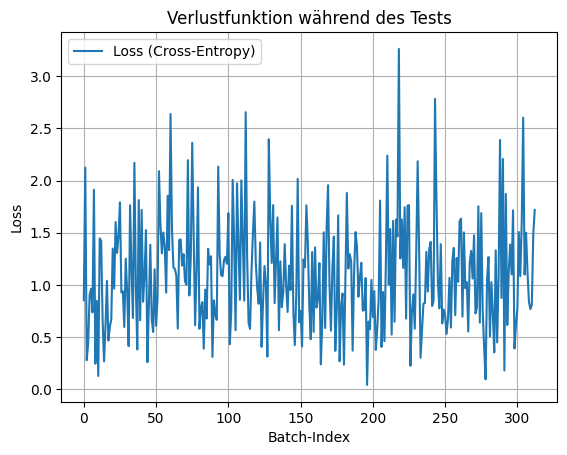

Accuracy (CNN): 81.52%
Precision (macro): 0.8158
Recall (macro):    0.8152
F1-Score (macro):  0.8154
F = 0.000, p = 1.000
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1000
           1       0.91      0.90      0.90      1000
           2       0.77      0.74      0.75      1000
           3       0.65      0.68      0.67      1000
           4       0.79      0.80      0.79      1000
           5       0.73      0.72      0.72      1000
           6       0.86      0.85      0.86      1000
           7       0.87      0.83      0.85      1000
           8       0.89      0.90      0.89      1000
           9       0.87      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from scipy.stats import f_oneway

loss_values = []
cnn_model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        loss = cnn_loss_fn(outputs, labels)
        loss_values.append(loss.item())
    
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot der Verlustkurve
plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy (CNN): {100 * correct / total:.2f}%')
print(f'Precision (macro): {precision:.4f}')
print(f'Recall (macro):    {recall:.4f}')
print(f'F1-Score (macro):  {f1:.4f}')

report = classification_report(all_labels, all_preds, zero_division=0)
f_stat, p_val = f_oneway(all_labels, all_labels)
print(f"F = {f_stat:.3f}, p = {p_val:.3f}")
print(report)
